In [1]:
#! pip install pydot-ng
#! pip install graphviz

In [1]:
import os 
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, InputLayer
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import Image

from tqdm.notebook import tqdm
import time

tqdm.pandas()

plt.rcParams["font.family"] = "Times New Roman"
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#tf.config.threading.set_intra_op_parallelism_threads(num_threads=10)

df = pd.read_csv('train_2_0.csv')
df2 = df.drop(df.columns[1:-2],axis=1)


X = np.load('X.npy')
Y = df2.Pawpularity  / 100

data_aug =  ImageDataGenerator(
    rotation_range = 15, 
    zoom_range = 0.15,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.1,
    horizontal_flip = True, 
    fill_mode = "nearest"
)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0) 

In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

,Id,Pawpularity,path
0,0007de18844b0dbbb5e1f607da0606e0,63,data/train/0007de18844b0dbbb5e1f607da0606e0.jpg
1,0009c66b9439883ba2750fb825e1d7db,42,data/train/0009c66b9439883ba2750fb825e1d7db.jpg
2,0013fd999caf9a3efe1352ca1b0d937e,28,data/train/0013fd999caf9a3efe1352ca1b0d937e.jpg
3,0018df346ac9c1d8413cfcc888ca8246,15,data/train/0018df346ac9c1d8413cfcc888ca8246.jpg
4,001dc955e10590d3ca4673f034feeef2,72,data/train/001dc955e10590d3ca4673f034feeef2.jpg
...,...,...,...
9851,ffbfa0383c34dc513c95560d6e1fdb57,15,data/train/ffbfa0383c34dc513c95560d6e1fdb57.jpg
9852,ffcc8532d76436fc79e50eb2e5238e45,70,data/train/ffcc8532d76436fc79e50eb2e5238e45.jpg
9853,ffdf2e8673a1da6fb80342fa3b119a20,20,data/train/ffdf2e8673a1da6fb80342fa3b119a20.jpg
9854,fff19e2ce11718548fa1c5d039a5192a,20,data/train/fff19e2ce11718548fa1c5d039a5192a.jpg


In [4]:
#переводит изображение в тензор
# path - путь к изображению
# img_w - выходная ширина изображения
# img_h - выходная высота изображения
def prep_image(path, img_w, img_h):
    orig_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(orig_img, channels=3)
    img = tf.cast(img, dtype=tf.float32) / 255.0
    img = tf.image.resize(img, (img_w, img_h))
    return img

(720, 405, 3)


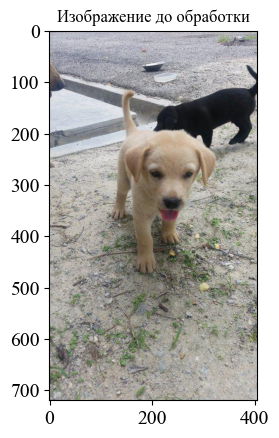

In [33]:
example_image = plt.imread(df2['path'][0])
plt.title('Изображение до обработки')
plt.imshow(example_image)
print(example_image.shape)

(128, 128, 3)


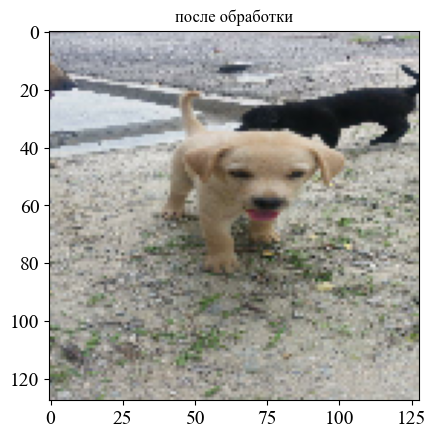

In [6]:
prep_example_img = prep_image(df2['path'][0], 128,128)
plt.title('после обработки')
plt.imshow(prep_example_img)
print(prep_example_img.shape)

In [ ]:
paths = df2.path
X = np.array([prep_image(p, 128, 128) for p in paths])
print(X.shape)

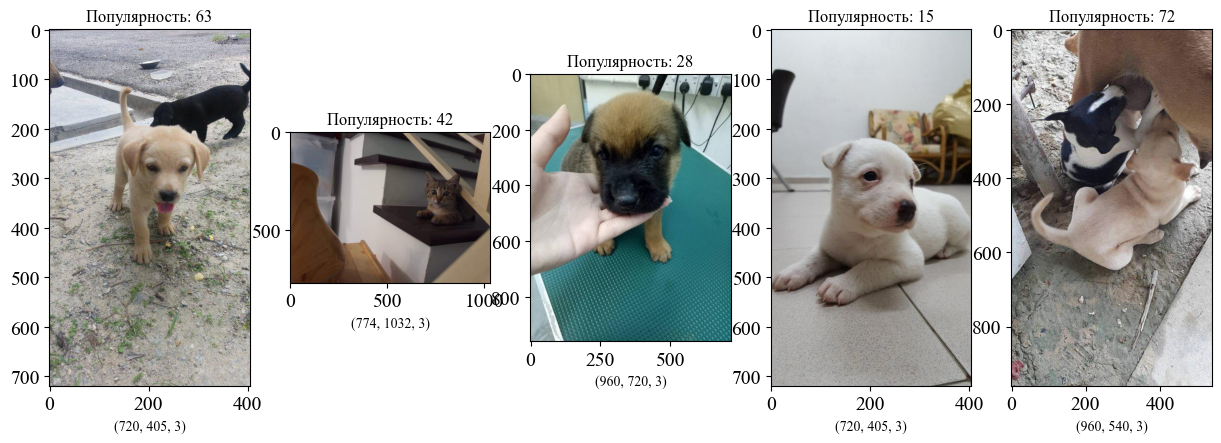

In [34]:
fig,ax = plt.subplots(1,5, figsize=(15,15))
for i in range(5):
    img=plt.imread(df.path[i])
    ax[i].imshow(img)
    ax[i].set_title(f"Популярность: {df.Pawpularity[i]}")
    ax[i].set_xlabel(img.shape)
plt.savefig('Photo before preprocessing')

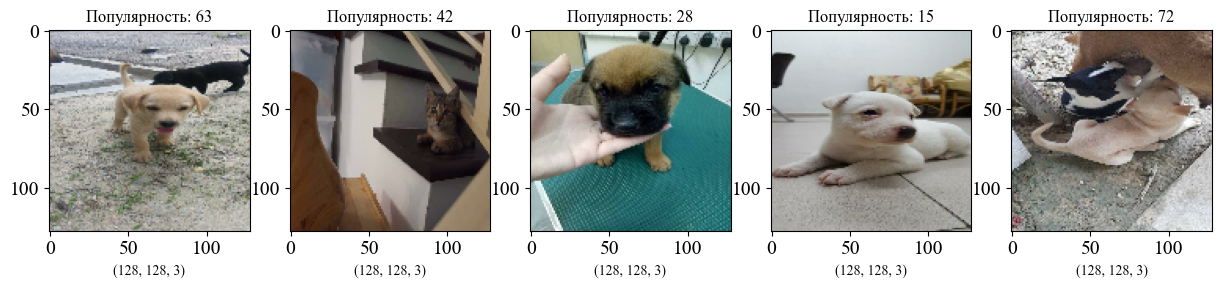

In [35]:
fig,ax = plt.subplots(1,5, figsize=(15,15))
for i in range(5):
    ax[i].imshow(X[i])
    ax[i].set_title(f"Популярность: {df.Pawpularity[i]}")
    ax[i].set_xlabel(X[i].shape)
plt.savefig('photo after preprocessing')

In [11]:
#np.save(file='X', arr=X)
#with tf.device("CPU"):
X = np.load('X.npy')
Y = df2.Pawpularity  / 100


In [4]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0) 

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(8870, 128, 128, 3)
(8870,)
(986, 128, 128, 3)
(986,)


In [5]:
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, InputLayer
from keras.utils.vis_utils import plot_model

## Первая модель

In [3]:
#with tf.device('CPU'):
model11 = Sequential(layers=[
        InputLayer(input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3])),
        Conv2D(32, (4,4), padding='same',activation='relu'),
        MaxPooling2D(padding='same'),
        Conv2D(64, (4,4), padding='same',activation='relu'),
        # MaxPooling2D(padding='same'),
        # Conv2D(128, (2,2), padding='same',activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(1)
    ],
    name='cnn.1'
    )

In [ ]:
model11.summary()

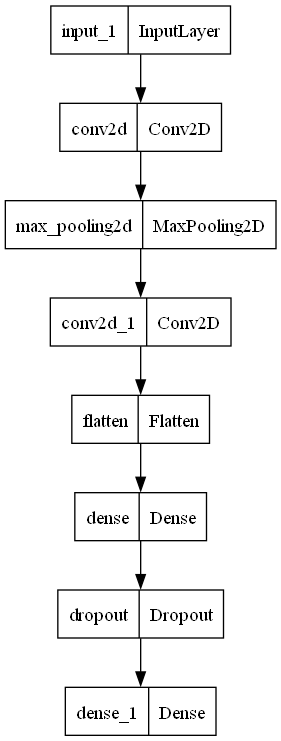

In [5]:
plot_model(model11, to_file='model11.png')

In [4]:
model11.compile(optimizer='adam', loss='mse', metrics=['mae', 
                                                     keras.metrics.RootMeanSquaredError(name='rmse'),
                                                        ])

In [5]:
#with tf.device('CPU'):
history1 = model11.fit(
                             X_train,
                             Y_train,
                             epochs=25,
                             verbose=1,
                             validation_split=0.2,
                             batch_size=16,
                             )

Epoch 1/25
444/444 [==============================] - ETA: 0s - loss: 3.6943 - mae: 0.3069 - rmse: 1.9221

ResourceExhaustedError: Graph execution error:

SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;726a370c73cbfb80;/job:localhost/replica:0/task:0/device:GPU:0;edge_12_IteratorGetNext;0:0
	 [[{{node IteratorGetNext/_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_3281]

In [19]:
model11.evaluate(X_train, Y_train)
model11.evaluate(X_test, Y_test)

31/31 [==============================] - 2s 74ms/step - loss: 0.0491 - mean_absolute_error: 0.1660 - root_mean_squared_error: 0.2217


[0.04914521425962448, 0.16597819328308105, 0.2216871976852417]

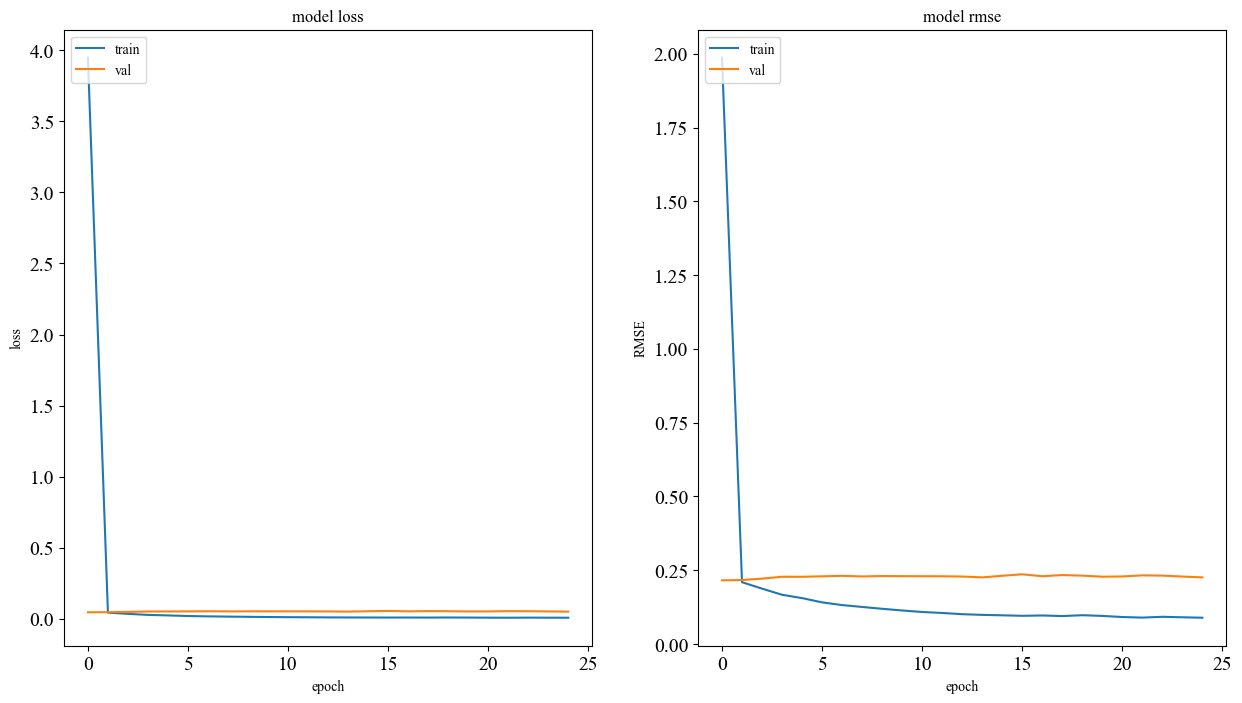

In [44]:
# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(history1.history['loss'])
ax[0].plot(history1.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history1.history['root_mean_squared_error'])
ax[1].plot(history1.history['val_root_mean_squared_error'])
ax[1].set_title('model rmse')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.savefig('model11_metrics.png')
plt.show()


In [24]:
pred1=model11.predict(X_test)

31/31 [==============================] - 2s 72ms/step


In [26]:
#pred1

In [32]:
df_res = pd.DataFrame(data=Y_test)
df_res['model1_pred'] = pred1

NameError: name 'pred1' is not defined

In [30]:
df_res

,Pawpularity,model2_pred
8094,0.03,0.329731
9764,0.26,0.337142
9090,0.22,0.370447
9075,0.03,0.349923
4807,0.28,0.319899
...,...,...
9200,0.25,0.419608
8269,0.27,0.397575
2119,0.24,0.351903
6071,0.41,0.307120


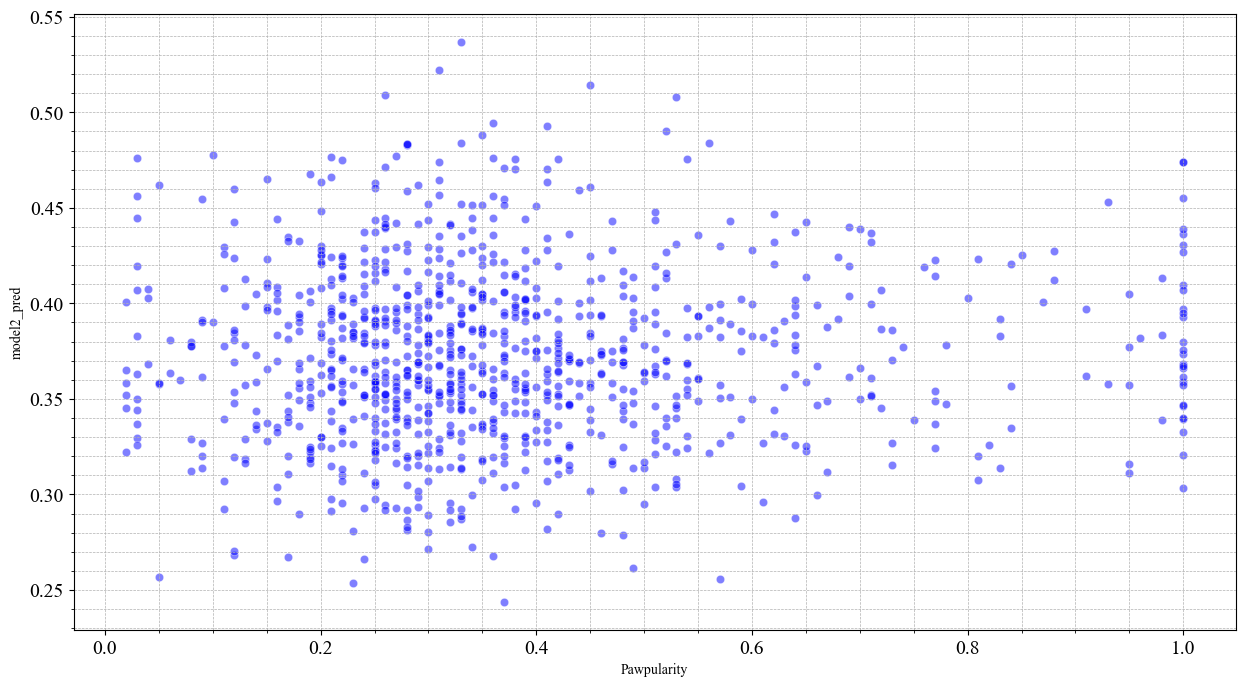

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=df_res, x='Pawpularity', y='model2_pred', markers=True, alpha=0.5, color='blue')

# Установка минорных делений на оси X и Y
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Добавление сетки
plt.grid(which='both', linestyle='--', linewidth=0.5)

# Сохранение графика
plt.savefig('scatter_with_grid_model2.png')

In [49]:
model11.save('model11')

INFO:tensorflow:Assets written to: model11\assets


INFO:tensorflow:Assets written to: model11\assets


## Вторая модель

In [ ]:
'''
model11 = Sequential(layers=[
    InputLayer(input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3])),
    Conv2D(32, (4,4), padding='same',activation='relu'),
    MaxPooling2D(padding='same'),
    Conv2D(64, (4,4), padding='same',activation='relu'),
    # MaxPooling2D(padding='same'),
    # Conv2D(128, (2,2), padding='same',activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1)
],
name='cnn.1'
)
'''

In [17]:
model2 = Sequential(layers=[
    InputLayer(input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3])),
    BatchNormalization(),
    Conv2D(32,(6,6),padding='same', activation='relu'),               
    BatchNormalization(),
    MaxPooling2D(padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1)               
    ],
    name='cnn.2'
)

In [18]:
model2.summary()

Model: "cnn.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      3488      
                                                                 
 batch_normalization_7 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                             

In [19]:
model2.compile(optimizer='adam', loss=keras.losses.mean_squared_error, metrics=[keras.metrics.mean_absolute_error, keras.metrics.RootMeanSquaredError()])

In [20]:
history2 = model2.fit(X_train, 
                      Y_train,
                      epochs=15,
                      verbose=1,
                      validation_split=0.2,
                      batch_size=16)

Epoch 1/15
444/444 [==============================] - 115s 259ms/step - loss: 1.0501 - mean_absolute_error: 0.7563 - root_mean_squared_error: 1.0247 - val_loss: 0.0800 - val_mean_absolute_error: 0.2210 - val_root_mean_squared_error: 0.2829
Epoch 2/15
444/444 [==============================] - 114s 258ms/step - loss: 0.2458 - mean_absolute_error: 0.3735 - root_mean_squared_error: 0.4958 - val_loss: 0.0512 - val_mean_absolute_error: 0.1661 - val_root_mean_squared_error: 0.2263
Epoch 3/15
444/444 [==============================] - 115s 258ms/step - loss: 0.0821 - mean_absolute_error: 0.2171 - root_mean_squared_error: 0.2865 - val_loss: 0.0457 - val_mean_absolute_error: 0.1548 - val_root_mean_squared_error: 0.2137
Epoch 4/15
444/444 [==============================] - 115s 258ms/step - loss: 0.0495 - mean_absolute_error: 0.1656 - root_mean_squared_error: 0.2225 - val_loss: 0.0456 - val_mean_absolute_error: 0.1545 - val_root_mean_squared_error: 0.2136
Epoch 5/15
444/444 [====================

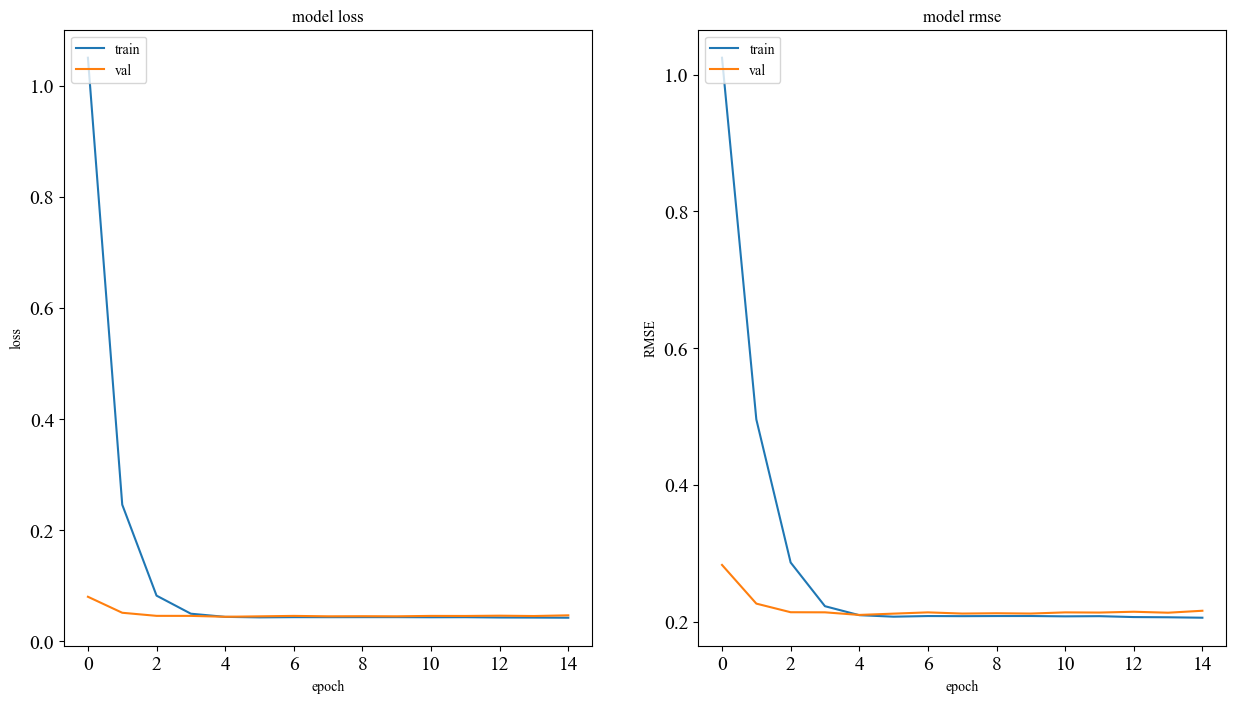

In [21]:
# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(history2.history['loss'])
ax[0].plot(history2.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history2.history['root_mean_squared_error'])
ax[1].plot(history2.history['val_root_mean_squared_error'])
ax[1].set_title('model rmse')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.savefig('model2_metrics.png')
plt.show()


In [22]:
model2.evaluate(X_train, Y_train)
model2.evaluate(X_test, Y_test)


31/31 [==============================] - 2s 73ms/step - loss: 0.0438 - mean_absolute_error: 0.1571 - root_mean_squared_error: 0.2093


[0.04380498453974724, 0.15709127485752106, 0.20929640531539917]

In [23]:
pred2 = model2.predict(X_test)

31/31 [==============================] - 2s 69ms/step


In [33]:
df_res = pd.DataFrame(data=Y_test)
df_res['model2_pred'] = pred2
df_res

,Pawpularity,model2_pred
8094,0.03,0.329731
9764,0.26,0.337142
9090,0.22,0.370447
9075,0.03,0.349923
4807,0.28,0.319899
...,...,...
9200,0.25,0.419608
8269,0.27,0.397575
2119,0.24,0.351903
6071,0.41,0.307120


In [34]:
r2_score(Y_test, pred2)

-0.036506923837207106

In [35]:
model2.save('model2')

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


## Третья модель

In [4]:
# глубокая модель
print(X_train.shape[1],X_train.shape[2], X_train.shape[3])


128 128 3


In [2]:
model3 = keras.Sequential(name='deepCNN3', layers=[
    InputLayer(input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3])),
    Conv2D(16, (8,8), strides=(2,2), padding='valid', activation='relu'),
    Conv2D(32, (4,4),  strides=(2,2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, (4,4),  strides=(2,2), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (4,4),  strides=(2,2), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(128, (4,4),  strides=(2,2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, (4,4),  strides=(2,2), padding='same', activation='relu'),
    BatchNormalization(),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(1),
])

In [3]:
model3.summary()

Model: "deepCNN3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 16)        3088      
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 32)        8224      
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256

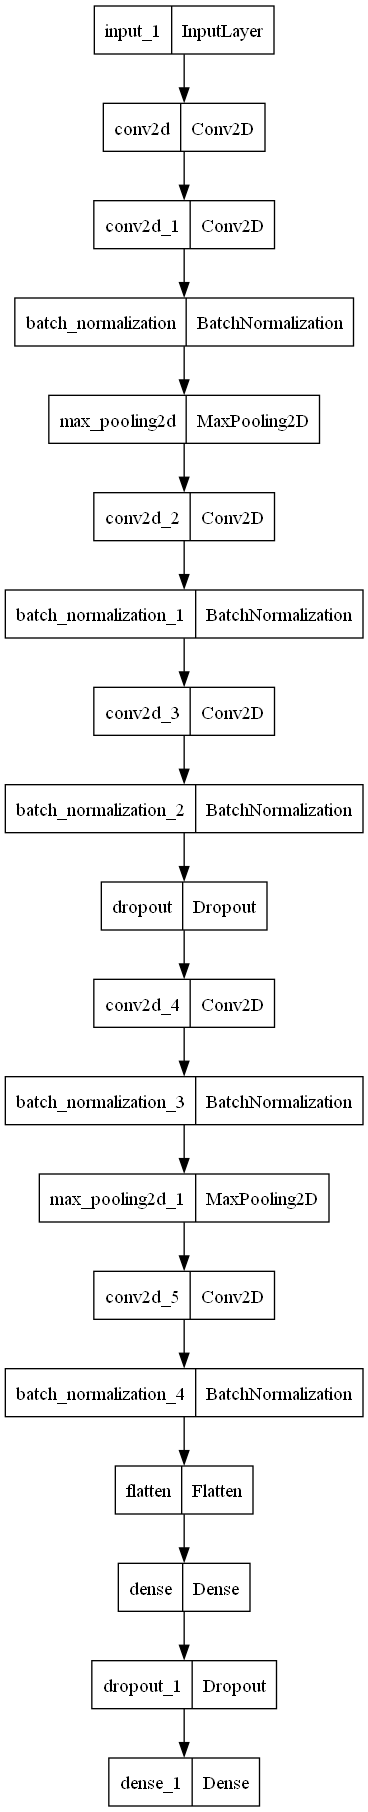

In [4]:
plot_model(model3, to_file='model3.png')

In [5]:
model3.compile(optimizer='Adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError(name='rmse'),
                                                     'mae'])

In [6]:
hist3=model3.fit(X_train, 
           Y_train, 
          epochs=25,
          batch_size=16,
          verbose=1,
          validation_split=0.2,)

Epoch 1/25
444/444 [==============================] - 11s 16ms/step - loss: 0.1225 - rmse: 0.3499 - mae: 0.2643 - val_loss: 0.0539 - val_rmse: 0.2322 - val_mae: 0.1719
Epoch 2/25
444/444 [==============================] - 6s 13ms/step - loss: 0.0588 - rmse: 0.2424 - mae: 0.1838 - val_loss: 0.0525 - val_rmse: 0.2292 - val_mae: 0.1780
Epoch 3/25
444/444 [==============================] - 6s 13ms/step - loss: 0.0491 - rmse: 0.2217 - mae: 0.1670 - val_loss: 0.0513 - val_rmse: 0.2265 - val_mae: 0.1662
Epoch 4/25
444/444 [==============================] - 6s 13ms/step - loss: 0.0458 - rmse: 0.2140 - mae: 0.1595 - val_loss: 0.0474 - val_rmse: 0.2177 - val_mae: 0.1579
Epoch 5/25
444/444 [==============================] - 6s 13ms/step - loss: 0.0448 - rmse: 0.2117 - mae: 0.1581 - val_loss: 0.0526 - val_rmse: 0.2293 - val_mae: 0.1635
Epoch 6/25
444/444 [==============================] - 6s 13ms/step - loss: 0.0441 - rmse: 0.2099 - mae: 0.1566 - val_loss: 0.0530 - val_rmse: 0.2303 - val_mae: 0.17

In [7]:
with tf.device('CPU'):
    model3.evaluate(X_train, Y_train)
    model3.evaluate(X_test, Y_test)


31/31 [==============================] - 1s 22ms/step - loss: 0.0550 - rmse: 0.2346 - mae: 0.1727


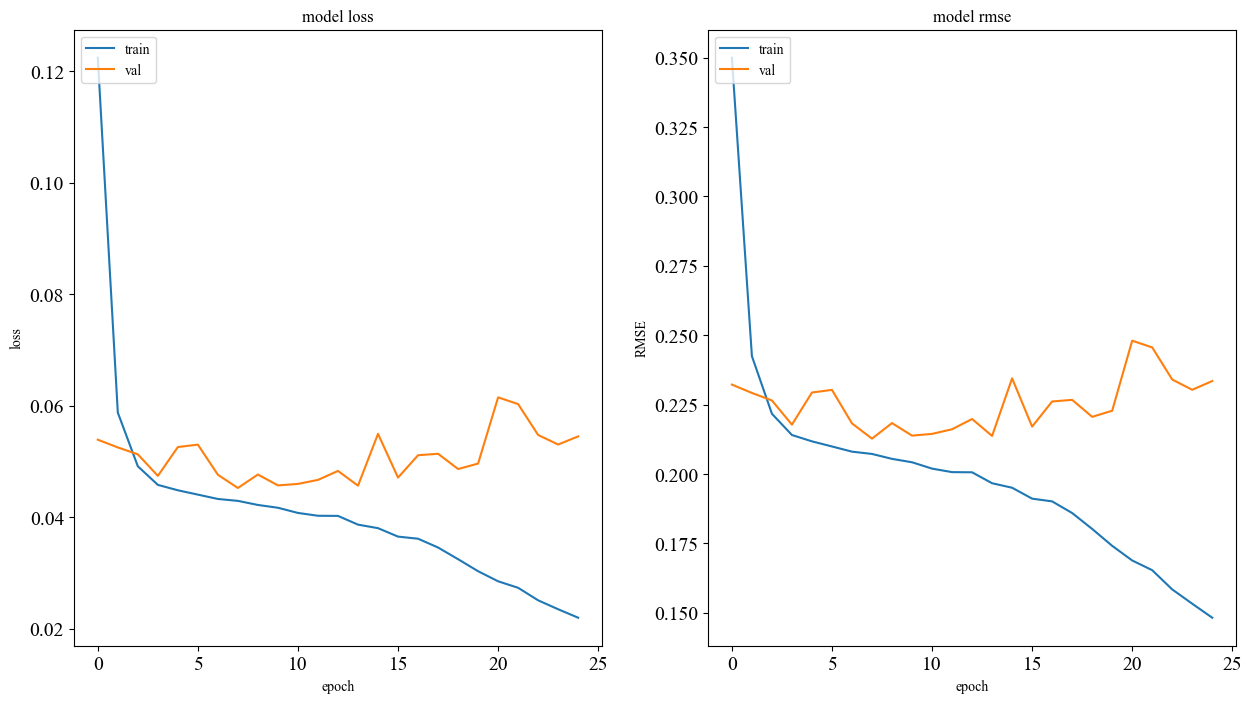

In [8]:
# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(hist3.history['loss'])
ax[0].plot(hist3.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(hist3.history['rmse'])
ax[1].plot(hist3.history['val_rmse'])
ax[1].set_title('model rmse')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.savefig('model3_metrics.png')
plt.show()


In [9]:
with tf.device('CPU'):
    pred3 = model3.predict(X_test)


31/31 [==============================] - 1s 19ms/step


In [10]:
print('rmse: ', root_mean_squared_error(Y_test, pred3))
print('mae: ', mean_absolute_error(Y_test, pred3))
print('r2_score: ', r2_score(Y_test, pred3))


rmse:  0.23458712644892832
mae:  0.17270631987835766
r2_score:  -0.30213792401632267


In [11]:
df_res = pd.DataFrame(data=Y_test)
df_res['model2_pred'] = pred3
df_res

,Pawpularity,model2_pred
8094,0.03,0.306703
9764,0.26,0.301788
9090,0.22,0.345505
9075,0.03,0.648514
4807,0.28,0.270898
...,...,...
9200,0.25,0.365745
8269,0.27,0.281251
2119,0.24,0.346613
6071,0.41,0.291895


In [12]:
print(df_res.Pawpularity.mean())
print(df_res.model2_pred.mean())
#Модель делает предсказания вблизи среднего

0.37649087221095334
0.37221923


In [13]:
df_res.to_excel('results.xlsx', sheet_name='model3')

In [5]:
# c аугментацией данных

hist3_2 = model3.fit(
    data_aug.flow(X_train,Y_train,batch_size=16),
    validation_data=(X_test,Y_test),
    epochs = 20,
    verbose = 1,
)

Epoch 1/20
555/555 [==============================] - 28s 44ms/step - loss: 0.1198 - rmse: 0.3461 - mae: 0.2589 - val_loss: 0.0561 - val_rmse: 0.2368 - val_mae: 0.1831
Epoch 2/20
555/555 [==============================] - 23s 42ms/step - loss: 0.0564 - rmse: 0.2374 - mae: 0.1809 - val_loss: 0.0446 - val_rmse: 0.2111 - val_mae: 0.1542
Epoch 3/20
555/555 [==============================] - 23s 41ms/step - loss: 0.0484 - rmse: 0.2201 - mae: 0.1657 - val_loss: 0.0475 - val_rmse: 0.2180 - val_mae: 0.1676
Epoch 4/20
555/555 [==============================] - 23s 41ms/step - loss: 0.0462 - rmse: 0.2148 - mae: 0.1607 - val_loss: 0.0443 - val_rmse: 0.2104 - val_mae: 0.1642
Epoch 5/20
555/555 [==============================] - 23s 41ms/step - loss: 0.0454 - rmse: 0.2130 - mae: 0.1597 - val_loss: 0.0455 - val_rmse: 0.2133 - val_mae: 0.1520
Epoch 6/20
555/555 [==============================] - 23s 41ms/step - loss: 0.0448 - rmse: 0.2115 - mae: 0.1582 - val_loss: 0.0435 - val_rmse: 0.2085 - val_mae:

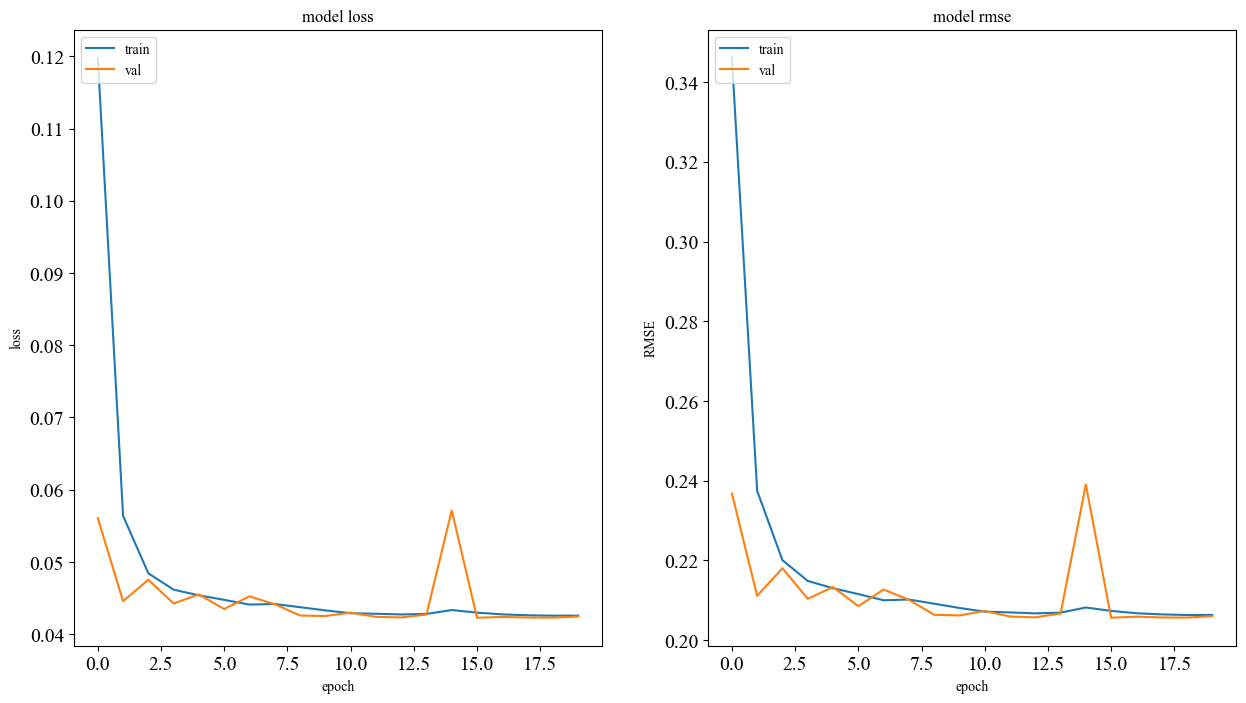

In [6]:
# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(hist3_2.history['loss'])
ax[0].plot(hist3_2.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(hist3_2.history['rmse'])
ax[1].plot(hist3_2.history['val_rmse'])
ax[1].set_title('model rmse')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.savefig('model3_metrics.png')
plt.show()


In [7]:
with tf.device('CPU'):
    model3.evaluate(X_train, Y_train)
    model3.evaluate(X_test, Y_test)


31/31 [==============================] - 1s 25ms/step - loss: 0.0424 - rmse: 0.2060 - mae: 0.1548


In [8]:
pred3_1 = model3.predict(X_test)


31/31 [==============================] - 1s 12ms/step


In [9]:
df_res = pd.DataFrame(Y_test)
df_res['model3_aug'] = pred3_1

In [11]:
df_res.to_excel('results.xlsx',sheet_name='model3_aug' )

In [12]:
df_res

,Pawpularity,model3_aug
8094,0.03,0.382478
9764,0.26,0.380573
9090,0.22,0.382478
9075,0.03,0.381150
4807,0.28,0.377784
...,...,...
9200,0.25,0.382478
8269,0.27,0.382478
2119,0.24,0.382478
6071,0.41,0.382478


## Efficient net
попробуем прикрутить эффективную сеть для решения задачи

In [2]:
from keras.applications import EfficientNetB0
ef_net =  EfficientNetB0(include_top=False,weights='imagenet',input_shape=(128,128,3))
ef_net.trainable = False

o = ef_net.output
o = BatchNormalization()(o)
o = Flatten()(o)
o = Dense(64, activation='relu')(o)
out_layer = Dense(1)(o)
model4 = keras.models.Model(inputs=ef_net.inputs, outputs=out_layer)

In [3]:
model4.compile(optimizer = 'adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError(name='rmse'),
                                                       'mae'])

In [ ]:
model4.summary()

In [ ]:
plot_model(model4, to_file='model4.png')

In [4]:
hist4 = model4.fit(X_train, 
           Y_train, 
          verbose=1,
          epochs=10,
          batch_size=16,
          validation_split=0.2)

Epoch 1/10
444/444 [==============================] - 28s 44ms/step - loss: 3.1370 - rmse: 1.7712 - mae: 0.2725 - val_loss: 0.0487 - val_rmse: 0.2207 - val_mae: 0.1516
Epoch 2/10
444/444 [==============================] - 16s 36ms/step - loss: 0.0442 - rmse: 0.2103 - mae: 0.1574 - val_loss: 0.0444 - val_rmse: 0.2107 - val_mae: 0.1617
Epoch 3/10
444/444 [==============================] - 16s 36ms/step - loss: 0.0437 - rmse: 0.2089 - mae: 0.1569 - val_loss: 0.0504 - val_rmse: 0.2245 - val_mae: 0.1530
Epoch 4/10
444/444 [==============================] - 16s 36ms/step - loss: 0.0444 - rmse: 0.2108 - mae: 0.1577 - val_loss: 0.0443 - val_rmse: 0.2106 - val_mae: 0.1548
Epoch 5/10
444/444 [==============================] - 16s 35ms/step - loss: 0.0446 - rmse: 0.2111 - mae: 0.1580 - val_loss: 0.0445 - val_rmse: 0.2110 - val_mae: 0.1628
Epoch 6/10
444/444 [==============================] - 16s 36ms/step - loss: 0.0447 - rmse: 0.2113 - mae: 0.1588 - val_loss: 0.0479 - val_rmse: 0.2189 - val_mae:

In [5]:
with tf.device('CPU'):
    model4.evaluate(X_train, Y_train)
    model4.evaluate(X_test, Y_test)
    

31/31 [==============================] - 12s 396ms/step - loss: 0.0428 - rmse: 0.2069 - mae: 0.1595


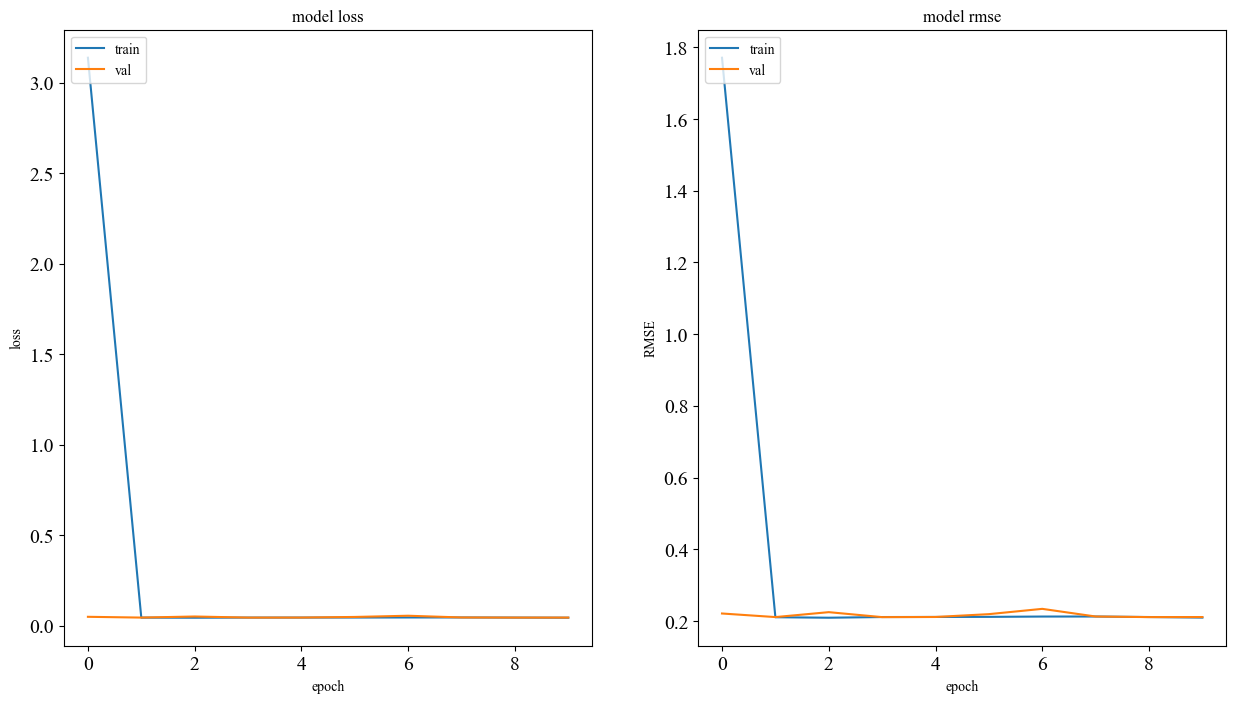

In [6]:
# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(hist4.history['loss'])
ax[0].plot(hist4.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(hist4.history['rmse'])
ax[1].plot(hist4.history['val_rmse'])
ax[1].set_title('model rmse')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.savefig('model3_metrics.png')
plt.show()


In [7]:
pred4 = model4.predict(X_test)
pred4

31/31 [==============================] - 4s 59ms/step


array([[0.40026546],
       [0.39821807],
       [0.39795563],
       [0.40162897],
       [0.4010187 ],
       [0.40217528],
       [0.40011165],
       [0.3979874 ],
       [0.40247136],
       [0.40278932],
       [0.40194634],
       [0.3888855 ],
       [0.40299568],
       [0.40048963],
       [0.40006667],
       [0.39585817],
       [0.39999285],
       [0.39894655],
       [0.40225244],
       [0.400859  ],
       [0.40267313],
       [0.39885432],
       [0.39923024],
       [0.40053585],
       [0.3997104 ],
       [0.40129516],
       [0.4000848 ],
       [0.3992048 ],
       [0.3993155 ],
       [0.39971295],
       [0.40073746],
       [0.40042433],
       [0.39836732],
       [0.40064904],
       [0.4006419 ],
       [0.40209994],
       [0.40290037],
       [0.40100032],
       [0.40053555],
       [0.39790097],
       [0.40196407],
       [0.39840403],
       [0.39785805],
       [0.39978787],
       [0.40202218],
       [0.40163592],
       [0.40216234],
       [0.401